TODO:
difference in importance of processing conditions across low vs high RH, (processing only change mechanical properties --> free water). 
1. Pretreated / un pretreated percentage change vs temperature (several lines at diff RH) 
    also plot delta lembda
2. lambda as f(drying temp) at different RH (%change)
3. MAD caculation between imputed and original

Evaluate imputed vs inherited on overlap (prove imputation quality) --> augmented dataset train general model --> plotting / parameter optimiztion with regard to delta lambda  

### Import Dependencies

In [1]:
import scipy as sp  #scientific computer package
import numpy as np   #math and array package
from numpy import exp, sqrt, pi, log, array   #math functions
import matplotlib.pyplot as plt  #plotting package
import seaborn as sns   #plotting style package

from openpyxl import load_workbook  #excel interface package
import xgboost as xgb
from xgboost import XGBRegressor
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

# TRI data - upload
dvs_data = pd.read_excel('./ChemRev_Hydration_Data.xlsx', sheet_name='HydrationData',
                        usecols = 'A:R')   #importing experimental data
thermo_fit_params=pd.read_csv('thermo_fit_params.csv')
#thermo_fit_params=pd.read_csv('thermo_fit_params.csv')
degree_celsius = '\u2103'
len(dvs_data)
#cols.remove('notes')
#cols = list(dvs_data.columns)
#dvs_data_melt = pd.melt(dvs_data, id_vars=['notes', '...''], value_vars = cols)
#dvs_data = dvs_data.sort_values(by=["study", "year", "RH", "PT"])

dvs_data.shape

c:\Users\andyt\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\andyt\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


(815, 18)

### DATA Organization
Drop some columns

In [2]:
not_include = ['Study','Year','Membrane','Cast','LV','RH_r','Pret_Time'] 
#max_features = ['Study','Year','Membrane']
dvs_data.drop(dvs_data[dvs_data['LV_id'] == 0.5].index, inplace = True)
dvs_data = dvs_data[dvs_data.Study != 'Alberti']
#dvs_data = dvs_data[dvs_data.Study != 'Berlinger']
#dvs_data = dvs_data[dvs_data.Study != 'Choi']
clean_fit_params=thermo_fit_params.drop(['Study','Year','Membrane','Cast'],axis=1)
df = dvs_data.drop(not_include, axis=1)
clean_fit_params.head(5)

,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,E0,beta_HM
0,1100,0,16,0,150,25,0,44,44,314236102.6,0.046085
1,1100,0,175,0,170,25,0,11,11,229768853.4,0.053402
2,1100,1,50,1,25,-10,0,7,7,236485214.6,0.087462
3,1200,1,50,1,25,25,0,8,8,291247257.3,-0.000515
4,1100,1,175,1,25,25,0,8,8,235940544.5,0.056327


## Make trainable data sets (df1,2,3)
- df1 is original df where thickness is is not null, drop equilibrium_hr
- df2 is original df where thickness is is not null, Equilibrium_hr is not null
- df3 is an alternative df1 where chempotential replaces RH & Temp

In [3]:
print('original dataset: ', df.shape)
# df.RH = df['RH']/100
df = df[df['lambda'].notnull()] # make sure we have lambda values entered
df = df[df['Thickness'].notnull()] # make sure we have thickness values entered

df_1_columns = df.columns.values.tolist() 
df_1_columns.remove('Equilibrium_hr')# dropping Equilib_hr
#df_1_columns.remove('ChemPotential')
#df_1_columns.remove('LV_id')
#df_1_columns.remove('RH') 
df_1 = df[df_1_columns]
print('dataset 1: ', df_1.shape)
df_1_l = df_1[df_1['LV_id']==1]  # real liquid
df_1_v = df_1[df_1['LV_id']==0]  # real vapor

df_2 = df[df['Equilibrium_hr'].notnull()] # original data where EQhr is not null 
print('dataset 2: ', df_2.shape)
df_2_l = df_2[df_2['LV_id']==1] 
print('dataset 2_l: ', df_2_l.shape)
df_2_v = df_2[df_2['LV_id']==0] 
print('dataset 2_v: ', df_2_v.shape)

df_3_columns = df.columns.values.tolist() 
df_3_columns.remove('Equilibrium_hr')# dropping Equilib_hr
df_3_columns.remove('RH')
df_3_columns.remove('Temperature') 
df_3_columns.remove('LV_id') 
df_3 = df[df_3_columns]
# df_3 = df_3[df_3.Pret_Time.notnull()]
#df_3=df_3.iloc[:100] #df3 is the complement of df1 where chempotential replaces RH & Temp
print('dataset 3: ', df_3.shape)

df_4_columns = df.columns.values.tolist() 
df_4_columns.remove('Equilibrium_hr')# dropping Equilib_hr
df_4_columns.remove('RH')
df_4_columns.remove('Temperature')
#df_4_columns.remove('LV_id') 
df_4 = df[df_4_columns]
print('dataset 4: ', df_4.shape)

df_5_columns = df.columns.values.tolist() 
df_5_columns.remove('Equilibrium_hr')# dropping Equilib_hr
df_5_columns.remove('ChemPotential')
#df_5_columns.remove('LV_id')
#df_5_columns.remove('RH') 
df_5 = df[df_5_columns]
df_5=df_5#.iloc[:500] #df5 is original df where thickness is is not null, drop chem potential
print('dataset 5: ', df_5.shape)
#careful of EQhr.

original dataset:  (652, 11)
dataset 1:  (621, 10)
dataset 2:  (454, 11)
dataset 2_l:  (117, 11)
dataset 2_v:  (337, 11)
dataset 3:  (621, 7)
dataset 4:  (621, 8)
dataset 5:  (621, 9)


In [4]:
df2_toImpute = pd.concat([df_2_l, df_2_v], ignore_index=True)
df2_toImpute = df2_toImpute.drop_duplicates(subset=['EW','Cast_id','Thickness','PT','Drying_Temp','Temperature','RH','LV_id'], keep='first')
df2_toImpute

,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential,Equilibrium_hr
0,1100,1,175.0,1,25,40.0,1.0,99.0,20.000000,11957.797674,10.0
1,1100,1,175.0,1,25,65.0,1.0,99.0,20.000000,12912.893335,10.0
2,1100,1,175.0,1,25,90.0,1.0,99.0,20.500000,13867.988996,10.0
3,1100,1,175.0,1,25,30.0,1.0,101.0,19.960000,11626.143929,10.0
4,1100,1,175.0,1,25,40.0,1.0,101.0,20.170000,12009.845049,10.0
...,...,...,...,...,...,...,...,...,...,...,...
416,1100,0,16.0,0,150,25.0,0.0,60.0,4.574678,10144.033446,2.0
417,1100,0,16.0,0,150,25.0,0.0,70.0,5.402108,10525.952854,2.0
418,1100,0,16.0,0,150,25.0,0.0,80.0,6.579400,10856.786493,2.0
419,1100,0,16.0,0,150,25.0,0.0,90.0,7.925636,11148.602445,2.0


In [5]:
df1_correspond = df_1_l.copy() 
df1_correspond['LV_id'] = 0       # an imaginary vapor version of the liquid experiments
df1_correspond['lambda']= None      # set lambdas to null to be imputed
df1_correspond['RH'] = df1_correspond['RH'].replace(100.1,100)
df1_toImpute = pd.concat([df1_correspond, df_1_v], ignore_index=True) 
#df1_toImpute.to_excel('pre-duplicateDrop1.xlsx')


In [6]:
overlap = pd.merge(df1_correspond, df_1_v, on=['EW','Cast_id','Thickness','PT','Drying_Temp','Temperature','RH','LV_id'], how = 'inner')
#overlap.to_excel('overlap.xlsx')
print(overlap.shape)

df1_toImpute['Dupe']=df1_toImpute[['EW','Cast_id','Thickness','PT','Drying_Temp','Temperature','RH','LV_id']].apply(tuple, axis = 1)\
    .isin(overlap[['EW','Cast_id','Thickness','PT','Drying_Temp','Temperature','RH','LV_id']].apply(tuple, axis = 1))
df1_toImpute = df1_toImpute.drop_duplicates(subset=['EW','Cast_id','Thickness','PT','Drying_Temp','Temperature','RH','LV_id'], keep='last')
df1_toImpute.to_excel('pre-impute-last1.xlsx')
reference_id = df1_toImpute[df1_toImpute['lambda'].isna()].sort_values('Temperature').index

(63, 12)


In [7]:
df_1_v[df_1_v.RH>95].shape

(43, 10)

In [8]:
df1_toImpute['Dupe']=df1_toImpute[['EW','Cast_id','Thickness','PT','Drying_Temp','Temperature','RH','LV_id']].apply(tuple, axis = 1)\
    .isin(overlap[['EW','Cast_id','Thickness','PT','Drying_Temp','Temperature','RH','LV_id']].apply(tuple, axis = 1))

In [9]:
df1_toImpute

,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential,Dupe
0,1100,1,175.0,1,105,25.0,0.0,100.0,NaN,11412.117042,False
5,1100,1,175.0,1,25,40.0,0.0,99.0,NaN,11957.797674,False
6,1100,1,175.0,1,25,65.0,0.0,99.0,NaN,12912.893335,False
7,1100,1,175.0,1,25,90.0,0.0,99.0,NaN,13867.988996,False
8,1100,1,175.0,1,25,30.0,0.0,101.0,NaN,11626.143929,False
...,...,...,...,...,...,...,...,...,...,...,...
616,1100,0,16.0,0,150,25.0,0.0,60.0,4.530136,10144.033446,False
617,1100,0,16.0,0,150,25.0,0.0,70.0,5.303879,10525.952854,False
618,1100,0,16.0,0,150,25.0,0.0,80.0,6.430028,10856.786493,False
619,1100,0,16.0,0,150,25.0,0.0,90.0,7.734861,11148.602445,False


In [10]:
df_1_v[df_1_v['Drying_Temp'] == 100]

,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential
591,1100,0,50.0,1,100,60.0,0.0,11.00,0.88,6638.721732
592,1100,0,50.0,1,100,60.0,0.0,30.00,2.65,9416.425825
593,1100,0,50.0,1,100,60.0,0.0,40.75,3.24,10264.321354
594,1100,0,50.0,1,100,60.0,0.0,50.15,5.29,10838.971488
595,1100,0,50.0,1,100,60.0,0.0,75.08,6.18,11956.185086
596,1100,0,50.0,1,100,60.0,0.0,95.93,12.06,12634.661478
613,1100,0,50.0,1,100,30.0,0.0,56.45,8.54,10160.594713
614,1100,0,50.0,1,100,30.0,0.0,68.22,9.04,10637.676089
615,1100,0,50.0,1,100,30.0,0.0,75.00,10.24,10876.365641
616,1100,0,50.0,1,100,30.0,0.0,84.00,11.25,11161.856692


In [11]:
[1,2,3].pop()

3

In [12]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
knn = KNNImputer(n_neighbors=7, weights='distance') # 
it = IterativeImputer(sample_posterior=True)
# 
imputed_df1_knn = pd.DataFrame(knn.fit_transform(df1_toImpute), columns=list(df1_toImpute.columns).remove('Dupe'))
#imputed_df1_it = pd.DataFrame(it.fit_transform(df1_toImpute), columns=df1_toImpute.columns)

In [13]:
df_improved = pd.concat([imputed_df1_knn,df_1_l], ignore_index= True)

In [14]:
#pd.merge(imputed_df1_knn, df_1_l, on= ['EW','Cast_id','Thickness','PT','Drying_Temp','Temperature','RH']).to_excel('lambda4d.xlsx')

In [15]:
imputed_df1_knn.loc[reference_id].to_excel('imputed_knn.xlsx')

In [16]:
#imputed_df1_it.loc[reference_id].to_excel('imputed_it.xlsx')

In [17]:
df_2_pt = df_2.copy(deep=True)
df_2_pt['PT_dry'] = df_2_pt.PT * df_2_pt.Drying_Temp
df_2_pt = df_2_pt.drop(['PT','Drying_Temp'],axis = 1)
df_2_pt

,EW,Cast_id,Thickness,Temperature,LV_id,RH,lambda,ChemPotential,Equilibrium_hr,PT_dry
155,1100,1,175.0,22.0,0.0,99.0,14.500000,11270.128798,48.0,120
156,1100,1,175.0,25.0,0.0,99.0,14.000000,11384.740277,48.0,120
157,1100,1,175.0,30.0,0.0,99.0,12.500000,11575.759410,48.0,120
158,1100,1,175.0,36.0,0.0,99.0,10.500000,11804.982368,48.0,120
159,1100,1,175.0,44.0,0.0,99.0,10.000000,12110.612980,48.0,120
...,...,...,...,...,...,...,...,...,...,...
810,1100,0,16.0,25.0,0.0,60.0,4.530136,10144.033446,2.0,0
811,1100,0,16.0,25.0,0.0,70.0,5.303879,10525.952854,2.0,0
812,1100,0,16.0,25.0,0.0,80.0,6.430028,10856.786493,2.0,0
813,1100,0,16.0,25.0,0.0,90.0,7.734861,11148.602445,2.0,0


In [18]:
df_2.shape

(454, 11)

<b> Make_X_y (Data matrix, Validation Column)

In [19]:
def make_X_y(data_frame,param='lambda'):
    x_columns = data_frame.columns.values.tolist()
#    [x_columns.remove(x) for x in not_include if x in x_columns]
    y_column = param
    x_columns.remove(y_column)
    y = data_frame[y_column].values
    X = data_frame[x_columns].values
    return X, y, x_columns



In [20]:

X_1, y_1, x_columns_1 = make_X_y(df_1)
print(f'X_1: {X_1.shape}, y_1: {y_1.shape}')

X_1_l, y_1_l, x_columns_1_l = make_X_y(df_1_l) # liquid only
print(f'X_1_l: {X_1_l.shape}, y_1_l: {y_1_l.shape}')

X_2, y_2, x_columns_2 = make_X_y(df_2)
print(f'X_2: {X_2.shape}, y_2: {y_2.shape}')

X_2_l, y_2_l, x_columns_2_l = make_X_y(df_2_l) # liquid only
print(f'X_2_l: {X_2_l.shape}, y_2_l: {y_2_l.shape}')

X_2_v, y_2_v, x_columns_2_v = make_X_y(df_2_v) # vapor only
print(f'X_2_v: {X_2_v.shape}, y_2_v: {y_2_v.shape}')

X_2_pt, y_2_pt, x_columns_2 = make_X_y(df_2_pt)
print(f'X_2: {X_2_pt.shape}, y_2: {y_2_pt.shape}')

X_3, y_3, x_columns_3 = make_X_y(df_3)
print(f'X_3: {X_3.shape}, y_3: {y_3.shape}')

X_4, y_4, x_columns_4 = make_X_y(df_4)
print(f'X_4: {X_4.shape}, y_4: {y_4.shape}')


X_5, y_5, x_columns_5 = make_X_y(df_5)
print(f'X_5: {X_5.shape}, y_5: {y_5.shape}')

X_improved, y_improved, x_columns_improved = make_X_y(df_improved)
print(f'X_improved: {X_improved.shape}, y_improved: {y_improved.shape}')

X_1: (621, 9), y_1: (621,)
X_1_l: (144, 9), y_1_l: (144,)
X_2: (454, 10), y_2: (454,)
X_2_l: (117, 10), y_2_l: (117,)
X_2_v: (337, 10), y_2_v: (337,)
X_2: (454, 9), y_2: (454,)
X_3: (621, 6), y_3: (621,)
X_4: (621, 7), y_4: (621,)
X_5: (621, 8), y_5: (621,)
X_improved: (623, 20), y_improved: (623,)


In [21]:
def make_X_y_df(data_frame,param='lambda'):
    x_columns = data_frame.columns.values.tolist()
#    [x_columns.remove(x) for x in not_include if x in x_columns]
    y_column = param
    x_columns.remove(y_column)
    y = data_frame[y_column]
    X = data_frame[x_columns]
    return X, y, x_columns

X_1_df = make_X_y_df(df_1)[0]
X_1_df.reset_index();

<b> K-fold train/test split

In [22]:
def validate(X, y, regressor_class, n_splits = 8, **params):

    train_scores = list()
    test_scores = list()

    kf = KFold(n_splits, shuffle=True, random_state=1) 
   # shuffle: whether data is shuffled before being splited into k folds. Stable parameter selection should not depend on shuffling. mix sub-classes in data.
   
    for train_indices, test_indices in kf.split(X): # [(a_l,b_l),(a2_l, b2_l),()] --> a=[all indices not in box 0] = trianing data    b= [all indices in box 0]
                                                    # [(a_v, b_v), (a2_v, b2_v), ()]
                                                    # s1: a_l+(sim_v + a_v>95) + av<95, test: b_l+b_V
         X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]
        rg = regressor_class()
        rg.set_params(**params)
        rg.fit(X_train, y_train)
        train_scores.append(rg.score(X_train, y_train))
        test_scores.append(rg.score(X_test, y_test))

    print(f'mean train score: {np.round(np.mean(train_scores),4)}  \
          ---  mean test score: {np.round(np.mean(test_scores),4)} ---test min/max: {np.round(min(test_scores),4)} | {np.round(max(test_scores),4)}')
    #return [rg, np.mean(test_scores)] # returns the trained regressor and average test score across k folds
    #return np.mean(test_scores)

In [23]:
def fit_entire_data(X, y, regressor_class, print_score = True, **params):
    rg = regressor_class()
    rg.set_params(**params)
    rg.fit(X,y)
    if print_score:
        print(rg.score(X,y))
    return rg

rg_1 = fit_entire_data(X_1,y_1,RandomForestRegressor)
rg_2 = fit_entire_data(X_2,y_2,RandomForestRegressor)
rg_2_l = fit_entire_data(X_2_l, y_2_l,RandomForestRegressor)
rg_2_pt = fit_entire_data(X_2_pt,y_2_pt,RandomForestRegressor)
rg_3 = fit_entire_data(X_3,y_3),RandomForestRegressor
rg_4 = fit_entire_data(X_4,y_4,RandomForestRegressor)
rg_5 = fit_entire_data(X_5,y_5,RandomForestRegressor)
rg_improved = fit_entire_data(X_improved, y_improved,RandomForestRegressor)
rg_improved_xgb = fit_entire_data(X_improved, y_improved,XGBRegressor)

0.9892039302580341
0.9930604162791434
0.9571938551690377
0.9933532094286324


TypeError: fit_entire_data() missing 1 required positional argument: 'regressor_class'

## Define Custom Objective Function

In [ ]:

# (vapor_pred - vap_real)^2 + abs(min(0, vapor_pred - liq_real))

vap_pred = [1,2,3,4]
li1_real = [3,3,2,4]
2(vapr_pred - vap_real)
def gradient(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the gradient'''
    y = dtrain.
    bool_array = predt < liq_real:
    return (np.log1p(predt) - np.log1p(y)) / (predt + 1)

def hessian(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the hessian (2nd derivative)'''
    y = dtrain.get_label()
    return ((-np.log1p(predt) + np.log1p(y) + 1) /
            np.power(predt + 1, 2))

def squared_log(predt: np.ndarray, dtrain: xgb.DMatrix):
    '''Squared Log Error objective. A simplified version for RMSLE used as
    objective function.
    '''
    predt[predt < -1] = -1 + 1e-6
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess

In [19]:
mpg_X_train, mpg_X_test, mpg_y_train, mpg_y_test = train_test_split(
    X_2,
    y_2,
    test_size=0.25,
    random_state=42,
    shuffle= True)
rg_2_partial = RandomForestRegressor()
rg_2_partial.fit(mpg_X_train, mpg_y_train)

RandomForestRegressor()

In [31]:
validate(X_1,y_1, RandomForestRegressor)
validate(X_1_l, y_1_l, RandomForestRegressor)
print("-"*10)
print('Original:')
validate(X_2,y_2, RandomForestRegressor)
validate(X_2_l, y_2_l, RandomForestRegressor)
validate(X_2_v, y_2_v, RandomForestRegressor)
print("-"*10)
print("Drying Temp x PT:")
validate(X_2_pt,y_2_pt, RandomForestRegressor)
print("-"*10)
validate(X_3,y_3, RandomForestRegressor)
validate(X_4,y_4, RandomForestRegressor)
validate(X_5,y_5, RandomForestRegressor)
print("-"*10)
print("Imputed: (rf followed by xgboost)")
validate(X_improved, y_improved, RandomForestRegressor)
validate(X_improved,y_improved, XGBRegressor)

mean train score: 0.9895            ---  mean test score: 0.952 ---test min/max: 0.9253 | 0.9705
mean train score: 0.9332            ---  mean test score: 0.75 ---test min/max: 0.6416 | 0.8581
----------
Original:
mean train score: 0.9932            ---  mean test score: 0.9607 ---test min/max: 0.9374 | 0.9731
mean train score: 0.9559            ---  mean test score: 0.7597 ---test min/max: 0.5933 | 0.8516
mean train score: 0.9882            ---  mean test score: 0.9282 ---test min/max: 0.8631 | 0.9639
----------
Drying Temp x PT:
mean train score: 0.9931            ---  mean test score: 0.9595 ---test min/max: 0.9346 | 0.9741
----------
mean train score: 0.9687            ---  mean test score: 0.8119 ---test min/max: 0.669 | 0.8961
mean train score: 0.982            ---  mean test score: 0.906 ---test min/max: 0.8478 | 0.9405
mean train score: 0.9894            ---  mean test score: 0.9524 ---test min/max: 0.9281 | 0.9712
----------
Imputed: (rf followed by xgboost)
mean train score: 

- Since lv_id is the only difference in df3 and df4 (df3 knows and df4 doesn't), the rg_3 has no way of accounting for shroeder's paradox, see the difference in test score across df3 and df4 ()
- comparing df4 to df1 --> examine chempotential as a replacement for rh & temperature

In [60]:
def plot_feature_importance(df_i, rg, title='RandomForest'):
    feature_importances = rg.feature_importances_
    feature_names = df_i.columns.to_list() # Replace with your actual feature names
    feature_names.remove('lambda')

    sorted_features = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=False)
    print(sorted_features)
    names = [i[0] for i in sorted_features]
    vals = [i[1] for i in sorted_features]
    # Create a horizontal bar plot
    plt.figure(figsize=(10, 3))  # Adjust the figure size as needed
    plt.barh(names, vals, color='skyblue')
    plt.xlim([0,1])
    plt.ylabel('Feature Names')
    plt.title(f'{title} Feature Importance')
    # Show the plot
    plt.show()

In [ ]:
plot_feature_importance(df_1, rg_1, 'rg1')
plot_feature_importance(df_2, rg_2, 'rg2')
plot_feature_importance(df_2_pt, rg_2_pt, 'rg2_pt')
plot_feature_importance(df_3, rg_3, 'rg3')
plot_feature_importance(df_4, rg_4, 'rg4')
plot_feature_importance(df_5, rg_5, 'rg5')

In [47]:
def chem_pot(rh,T):
    return 8.314*(T+273.15)*np.log(rh+0.01/100)

In [48]:
df_2.columns

Index(['EW', 'Cast_id', 'Thickness', 'PT', 'Drying_Temp', 'Temperature',
       'LV_id', 'RH', 'lambda', 'ChemPotential', 'Equilibrium_hr'],
      dtype='object')

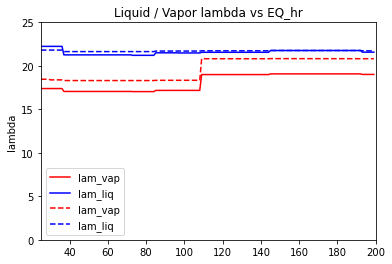

In [49]:
ew = 1100
cast = 1
thickness = 175
pt = 1
drying_temp = 25;
temp = 100
Eq_hr = 125

eq_range = np.arange(25,200,1)
temp_range = np.arange(5,110,1)
#'EW', 'Cast_id', 'Thickness', 'PT', 'Drying_Temp', 'Temperature','LV_id', 'RH', 'lambda', 'ChemPotential', 'Equilibrium_hr'
X_vap = [[ew,cast,thickness,pt,drying_temp,30,0,100,chem_pot(100,30),hr] for hr in eq_range]
lam_vap = rg_2.predict(X_vap)
X_liq = [[ew,cast,thickness,pt,drying_temp,30,1,100,chem_pot(100,30),hr] for hr in eq_range]
lam_liq = rg_2.predict(X_liq)
X_vap1 = [[ew,cast,thickness,pt,drying_temp,80,0,100,chem_pot(100,80),hr] for hr in eq_range]
lam_vap1 = rg_2.predict(X_vap1)
X_liq1 = [[ew,cast,thickness,pt,drying_temp,80,1,100,chem_pot(100,80),hr] for hr in eq_range]
lam_liq1 = rg_2.predict(X_liq1)

lam_liq - lam_vap;
plt.plot(eq_range, lam_vap, label='lam_vap', color='red')
plt.plot(eq_range, lam_liq, label='lam_liq', color='blue')
plt.plot(eq_range, lam_vap1, label='lam_vap', color='red', linestyle = '--')
plt.plot(eq_range, lam_liq1, label='lam_liq', color='blue', linestyle = '--')
plt.ylabel('lambda')
plt.ylim([0,25])
plt.xlim([25,200])
plt.title('Liquid / Vapor lambda vs EQ_hr')
plt.legend()

In [ ]:
df.query('(Temperature>=25) &  (Temperature < 40) LV_id == 0')

,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential,Equilibrium_hr
156,1100,1,175.0,1,120,25.0,0.0,99.0,14.000000,11384.740277,48.0
157,1100,1,175.0,1,120,30.0,0.0,99.0,12.500000,11575.759410,48.0
158,1100,1,175.0,1,120,36.0,0.0,99.0,10.500000,11804.982368,48.0
159,1100,1,175.0,1,120,44.0,0.0,99.0,10.000000,12110.612980,48.0
160,1100,1,175.0,1,120,52.0,0.0,99.0,9.000000,12416.243591,48.0
...,...,...,...,...,...,...,...,...,...,...,...
810,1100,0,16.0,0,150,25.0,0.0,60.0,4.530136,10144.033446,2.0
811,1100,0,16.0,0,150,25.0,0.0,70.0,5.303879,10525.952854,2.0
812,1100,0,16.0,0,150,25.0,0.0,80.0,6.430028,10856.786493,2.0
813,1100,0,16.0,0,150,25.0,0.0,90.0,7.734861,11148.602445,2.0


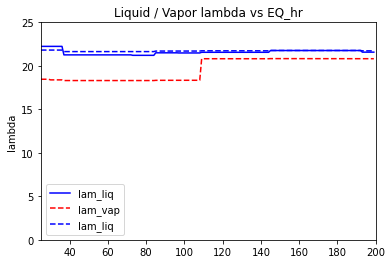

In [51]:
ew = 1100
cast = 1
thickness = 175
pt = 1
drying_temp = 25;
temp = 100
Eq_hr = 125

eq_range = np.arange(25,200,1)
temp_range = np.arange(5,110,1)
#'EW', 'Cast_id', 'Thickness', 'PT', 'Drying_Temp', 'Temperature','LV_id', 'RH', 'lambda', 'ChemPotential', 'Equilibrium_hr'
X_vap = [[ew,cast,thickness,pt,drying_temp,30,0,100,chem_pot(100,30),hr] for hr in eq_range]
lam_vap = rg_2.predict(X_vap)
X_liq = [[ew,cast,thickness,pt,drying_temp,30,1,100,chem_pot(100,30),hr] for hr in eq_range]
lam_liq = rg_2.predict(X_liq)
X_vap1 = [[ew,cast,thickness,pt,drying_temp,80,0,100,chem_pot(100,80),hr] for hr in eq_range]
lam_vap1 = rg_2.predict(X_vap1)
X_liq1 = [[ew,cast,thickness,pt,drying_temp,80,1,100,chem_pot(100,80),hr] for hr in eq_range]
lam_liq1 = rg_2.predict(X_liq1)

lam_liq - lam_vap;

# for tk in :
#     X_vap = [[ew,cast,tk,pt,drying_temp,30,0,100,chem_pot(100,30),hr] for hr in eq_range]
#     lam_vap = rg_2.predict(X_vap)
#     plt.plot(eq_range, lam_vap, label='lam_vap', color='red')




#plt.plot(eq_range, lam_vap, label='lam_vap', color='red')
plt.plot(eq_range, lam_liq, label='lam_liq', color='blue')
plt.plot(eq_range, lam_vap1, label='lam_vap', color='red', linestyle = '--')
plt.plot(eq_range, lam_liq1, label='lam_liq', color='blue', linestyle = '--')
plt.ylabel('lambda')
plt.ylim([0,25])
plt.xlim([25,200])
plt.title('Liquid / Vapor lambda vs EQ_hr')
plt.legend()

In [52]:
df_2.columns

Index(['EW', 'Cast_id', 'Thickness', 'PT', 'Drying_Temp', 'Temperature',
       'LV_id', 'RH', 'lambda', 'ChemPotential', 'Equilibrium_hr'],
      dtype='object')

In [53]:
df_2[df_2.Equilibrium_hr == 168].shape

(70, 11)

In [54]:
pt_liq=df_2.query('(EW==1100) & (Cast_id==1) & (Thickness ==175)& (PT==1) & (Drying_Temp >= 20) & (LV_id ==0) & (Drying_Temp <= 40) & (RH>90) & (RH < 110)')
pt_liq

,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential,Equilibrium_hr
256,1100,1,175.0,1,25,40.0,0.0,95.0,10.7560,11850.471865,10.0
262,1100,1,175.0,1,25,65.0,0.0,95.0,11.5830,12796.995177,10.0
267,1100,1,175.0,1,25,90.0,0.0,95.0,12.8690,13743.518489,10.0
296,1100,1,175.0,1,25,40.0,0.0,95.0,10.6100,11850.471865,10.0
297,1100,1,175.0,1,25,65.0,0.0,95.0,11.4500,12796.995177,10.0
298,1100,1,175.0,1,25,90.0,0.0,95.0,12.8200,13743.518489,10.0
377,1100,1,175.0,1,25,25.0,0.0,95.0,13.8757,11282.557878,2.0
388,1100,1,175.0,1,25,50.0,0.0,95.0,13.7229,12229.081190,2.0


Impute

In [31]:
import forestci as fci

Failed to import duecredit due to No module named 'duecredit'


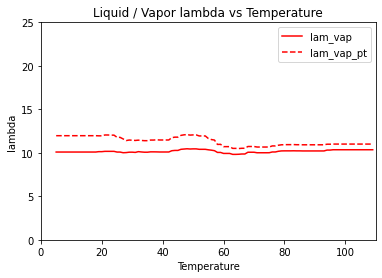

In [55]:
ew = 1100
cast = 1
thickness = 175
pt = 0
drying_temp = 25;
Eq_hr = 2
rh=93
#group 1
eq_range = np.arange(25,200,1)
temp_range = np.arange(5,110,1)
plot_range = np.arange(25,200,5)
X_vap = [[ew,cast,thickness,pt,drying_temp,t,0,rh,chem_pot(rh,t),Eq_hr] for t in temp_range]
# X_vap_test = [[ew,cast,thickness,pt,drying_temp,t,0,95,chem_pot(95,t),Eq_hr] \
#               for t in plot_range]
lam_vap = rg_2.predict(X_vap)

temp_range = np.arange(5,110,1)
X_vap1 = [[ew,cast,thickness,1,drying_temp,t,0,rh,chem_pot(rh,t),Eq_hr] for t in temp_range]
lam_vap1 = rg_2.predict(X_vap1)

plt.plot(temp_range, lam_vap, label='lam_vap', color='red')
# plt.plot(temp_range, lam_liq, label='lam_liq', color='blue')
plt.plot(temp_range, lam_vap1, label='lam_vap_pt', color='red', linestyle = '--')
# plt.plot(temp_range, lam_liq1, label='lam_liq_pt', color='blue', linestyle = '--')

plt.xlabel('Temperature')
plt.ylabel('lambda')
plt.ylim([0,25])
plt.xlim([0,110])
plt.title('Liquid / Vapor lambda vs Temperature')
plt.legend()

In [109]:
df_2.head(1)

,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential,Equilibrium_hr
155,1100,1,175.0,1,120,22.0,0.0,99.0,14.5,11270.128798,48.0


In [78]:
df_2.Drying_Temp.value_counts()

25     275
150     44
60      38
80      29
100     21
120     16
85      16
105     15
Name: Drying_Temp, dtype: int64

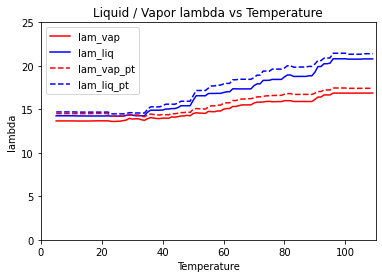

In [108]:
ew = 1100
cast = 1
thickness = 175
pt = 0
drying_temp = 80;
temp = 100
Eq_hr = 2
#group 1
eq_range = np.arange(25,200,1)
temp_range = np.arange(5,110,1)
X_vap = [[ew,cast,thickness,pt,drying_temp,t,0,100,chem_pot(100,t),Eq_hr] for t in temp_range]
lam_vap = rg_2.predict(X_vap)
X_liq = [[ew,cast,thickness,pt,drying_temp,t,1,100,chem_pot(100,t),Eq_hr] for t in temp_range]
lam_liq = rg_2.predict(X_liq)
#group2
temp_range = np.arange(5,110,1)
X_vap1 = [[ew,cast,thickness,1,drying_temp,t,0,100,chem_pot(100,t),Eq_hr] for t in temp_range]
lam_vap1 = rg_2.predict(X_vap1)
X_liq1 = [[ew,cast,thickness,1,drying_temp,t,1,100,chem_pot(100,t),Eq_hr] for t in temp_range]
lam_liq1 = rg_2.predict(X_liq1)



lam_liq - lam_vap;
plt.plot(temp_range, lam_vap, label='lam_vap', color='red')
plt.plot(temp_range, lam_liq, label='lam_liq', color='blue')
plt.plot(temp_range, lam_vap1, label='lam_vap_pt', color='red', linestyle = '--')
plt.plot(temp_range, lam_liq1, label='lam_liq_pt', color='blue', linestyle = '--')

# experimental data scatter
#plt.scatter(pt_liq.Temperature, pt_liq['lambda'],color = 'red')

plt.xlabel('Temperature')
plt.ylabel('lambda')
plt.ylim([0,25])
plt.xlim([0,110])
plt.title('Liquid / Vapor lambda vs Temperature')
plt.legend()

In [73]:
ew = 1100
cast = 1
thickness = 175
pt = 0
drying_temp = 25;
temp = 100
Eq_hr = 2
rh = 30
#group 1
eq_range = np.arange(25,200,1)
temp_range = np.arange(5,110,1)
plot_range = np.arange(25,200,5)
X_vap = [[ew,cast,thickness,pt,drying_temp,t,0,rh,chem_pot(rh,t),Eq_hr] for t in temp_range]
# X_vap_test = [[ew,cast,thickness,pt,drying_temp,t,0,95,chem_pot(95,t),Eq_hr] \
#               for t in plot_range]
lam_vap = rg_2_partial.predict(X_vap)
# lam_vap_plot = rg_2_partial.predict(X_vap_test)
# X_liq = [[ew,cast,thickness,pt,drying_temp,t,1,100,chem_pot(100,t),Eq_hr] for t in temp_range]
# lam_liq = rg_2_partial.predict(X_liq)
#group2
temp_range = np.arange(5,110,1)
X_vap1 = [[ew,cast,thickness,1,drying_temp,t,0,rh,chem_pot(rh,t),Eq_hr] for t in temp_range]
lam_vap1 = rg_2_partial.predict(X_vap1)
# X_liq1 = [[ew,cast,thickness,1,drying_temp,t,1,100,chem_pot(100,t),Eq_hr] for t in temp_range]
# lam_liq1 = rg_2_partial.predict(X_liq1)

# mpg_V_IJ_unbiased = fci.random_forest_error(rg_2,np.array(X_vap),
#                                             np.array(X_vap_test))

mpg_V_IJ_unbiased = fci.random_forest_error(rg_2_partial, np.array(mpg_X_train),
                                            np.array(X_vap_test))

plt.errorbar(plot_range, lam_vap_plot, yerr=np.sqrt(mpg_V_IJ_unbiased), fmt='o')
plt.plot(temp_range, lam_vap, label='lam_vap', color='red')
plt.plot(temp_range, lam_liq, label='lam_liq', color='blue')
plt.plot(temp_range, lam_vap1, label='lam_vap_pt', color='red', linestyle = '--')
plt.plot(temp_range, lam_liq1, label='lam_liq_pt', color='blue', linestyle = '--')

# experimental data scatter
plt.scatter(pt_liq.Temperature, pt_liq['lambda'],color = 'red')

plt.xlabel('Temperature')
plt.ylabel('lambda')
plt.ylim([0,25])
plt.xlim([0,110])
plt.title('Liquid / Vapor lambda vs Temperature')
plt.legend()

ValueError: X has 10 features, but DecisionTreeRegressor is expecting 9 features as input.

In [72]:
df_2_pt.head(1)

,EW,Cast_id,Thickness,Temperature,LV_id,RH,lambda,ChemPotential,Equilibrium_hr,PT_dry
155,1100,1,175.0,22.0,0.0,99.0,14.5,11270.128798,48.0,120


In [ ]:
def controlled_compare(regressor, control, feature_lst, default_vals, xAxisName = "Temperature", xAxisrange =np.arange(5,110,1)):
    feature_dict = dict(zip(feature_lst,default_vals))
    X_vap = [[feature_dict[key] if key!=xAxisName else t for key in feature_lst] for t in xAxisrange]
    

In [78]:
my_dict = {"a": 1, "b": 2, "c": 3, "Temperature": 4, "d": 5, "e": 6}
order = ["a", "b", "c", "Temperature", "d", "e"]

result = [[my_dict[key] if key in my_dict else t for key in order] for t in range(0, 10)]
result

[[1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6]]

PT vap

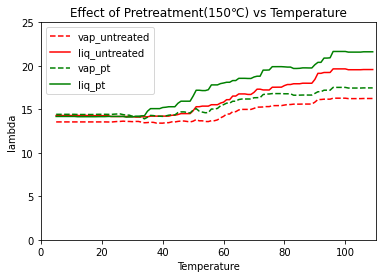

In [120]:
ew = 1100
cast = 1
thickness = 175
PT_dry = 80
temp = 100
Eq_hr = 2
#group 1
eq_range = np.arange(25,200,1)
temp_range = np.arange(5,110,1)
X_vap = [[ew,cast,thickness,t,0,100,chem_pot(100,t),Eq_hr,PT_dry] for t in temp_range]
lam_vap = rg_2_pt.predict(X_vap)
X_liq = [[ew,cast,thickness,t,1,100,chem_pot(100,t),Eq_hr,PT_dry] for t in temp_range]
lam_liq = rg_2_pt.predict(X_liq)
#group2
temp_range = np.arange(5,110,1)
X_vap1 = [[ew,cast,thickness,t,0,100,chem_pot(100,t),Eq_hr,0] for t in temp_range]
lam_vap1 = rg_2_pt.predict(X_vap1)
X_liq1 = [[ew,cast,thickness,t,1,100,chem_pot(100,t),Eq_hr,0] for t in temp_range]
lam_liq1 = rg_2_pt.predict(X_liq1)

lam_liq - lam_vap;
plt.plot(temp_range, lam_vap1, label='vap_untreated', color='red',linestyle = '--') #not pretreated
plt.plot(temp_range, lam_liq1, label='liq_untreated', color='red') # pretreated
plt.plot(temp_range, lam_vap, label='vap_pt', color='green', linestyle = '--')
plt.plot(temp_range, lam_liq, label='liq_pt', color='green', linestyle = '-')

# experimental data scatter
#plt.scatter(pt_liq.Temperature, pt_liq['lambda'],color = 'red')

plt.xlabel('Temperature')
plt.ylabel('lambda')
plt.ylim([0,25])
plt.xlim([0,110])

plt.title(f'Effect of Pretreatment(150{degree_celsius}) vs Temperature')
plt.legend()

single DT

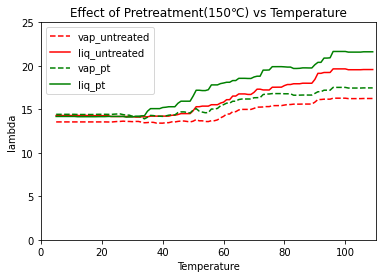

In [143]:
ew = 1100
cast = 1
thickness = 175
PT_dry = 80
rh = 100
Eq_hr = 2
#group 1
eq_range = np.arange(25,200,1)
temp_range = np.arange(5,110,1)
X_vap = [[ew,cast,thickness,t,0,100,chem_pot(100,t),Eq_hr,PT_dry] for t in temp_range]
lam_vap = rg_2_pt.predict(X_vap)
X_liq = [[ew,cast,thickness,t,1,100,chem_pot(100,t),Eq_hr,PT_dry] for t in temp_range]
lam_liq = rg_2_pt.predict(X_liq)
#group2
temp_range = np.arange(5,110,1)
X_vap1 = [[ew,cast,thickness,t,0,100,chem_pot(100,t),Eq_hr,0] for t in temp_range]
lam_vap1 = rg_2_pt.predict(X_vap1)
X_liq1 = [[ew,cast,thickness,t,1,100,chem_pot(100,t),Eq_hr,0] for t in temp_range]
lam_liq1 = rg_2_pt.predict(X_liq1)

lam_liq - lam_vap;
plt.plot(temp_range, lam_vap1, label='vap_untreated', color='red',linestyle = '--') #not pretreated
plt.plot(temp_range, lam_liq1, label='liq_untreated', color='red') 
plt.plot(temp_range, lam_vap, label='vap_pt', color='green', linestyle = '--')
plt.plot(temp_range, lam_liq, label='liq_pt', color='green', linestyle = '-')

# experimental data scatter
#plt.scatter(pt_liq.Temperature, pt_liq['lambda'],color = 'red')
mpg_V_IJ_unbiased = fci.random_forest_error(rg_2_pt, np.array(X_2_pt),
                                            np.array(X_vap_test))

plt.errorbar(plot_range, lam_vap_plot, yerr=np.sqrt(mpg_V_IJ_unbiased), fmt='o')

plt.xlabel('Temperature')
plt.ylabel('lambda')
plt.ylim([0,25])
plt.xlim([0,110])

plt.title(f'Effect of Pretreatment(150{degree_celsius}) vs Temperature')
plt.legend()

In [122]:
df_2.query('Drying_Temp == 25').Temperature.value_counts()

25.0     107
50.0      47
75.0      40
40.0      15
65.0      15
90.0      13
30.0       9
80.0       7
100.0      4
60.0       4
120.0      2
110.0      2
107.0      1
112.0      1
70.0       1
121.0      1
130.0      1
140.0      1
5.0        1
20.0       1
27.0       1
85.0       1
Name: Temperature, dtype: int64

In [126]:
np.sort(df_2.Drying_Temp.unique())

array([ 25,  60,  80,  85, 100, 105, 120, 150], dtype=int64)

In [ ]:
pt_liq=df_2.query('(EW==1100) & (Cast_id==0) & (Thickness ==50)& (PT==1)  & (LV_id ==0) & (Drying_Temp <= 100) & (RH>40) & (RH < 60)')
pt_liq

DT Vapor

[0.3859785955084402, 1.4323827675359153, 2.4065641870006695, 2.308644675855322, 2.599515510681072]


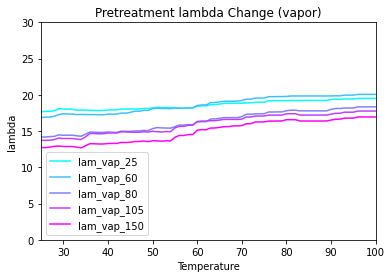

In [198]:
ew = 1100
cast = 0
thickness = 125
pt = 1
#drying_temp = 80;
#temp = 100
Eq_hr = 2
rh = 100
#group 1
eq_range = np.arange(25,200,1)
temp_range = np.arange(5,110,1)
variance_lst = []
drying_temp_range = [25, 60,80,105, 150]
styles = ['-','--',':', '-.']
cmap = plt.get_cmap('cool')
lam_noPT = rg_2.predict([[ew,cast,thickness,0,drying_temp_range[i],t,0,rh,chem_pot(rh,t),Eq_hr] for t in temp_range])
for i in range(0,len(drying_temp_range)):
    X_vap = [[ew,cast,thickness,pt,drying_temp_range[i],t,0,rh,chem_pot(rh,t),Eq_hr] for t in temp_range]
    lam_vap = rg_2.predict(X_vap)
    delta_lam = (lam_vap - lam_noPT) / lam_noPT

    #plt.plot(temp_range, lam_vap, label=f'lam_vap_{drying_temp_range[i]}', color='red', linestyle = styles[i])
    #plt.plot(temp_range, lam_liq, label=f'lam_liq_{drying_temp_range[i]}', color='blue',linestyle = styles[i]) 
    color = cmap(i / (len(drying_temp_range) - 1)) 
    variance_lst.append(np.var(lam_vap))

    #percent plot
    # plt.plot(temp_range, delta_lam, label=f'lam_vap_{drying_temp_range[i]}', color=color)    
    #raw plot
    plt.plot(temp_range, lam_vap, label=f'lam_vap_{drying_temp_range[i]}', color=color)    

  
    plt.legend()

#plt.plot(temp_range, lam_vap, label=f'lam_vap_noPT', color='black')    

# lam_liq - lam_vap;
# plt.plot(temp_range, lam_vap, label='lam_vap', color='red')
# plt.plot(temp_range, lam_liq, label='lam_liq', color='blue')
# #plt.plot(temp_range, lam_vap1, label='lam_vap_pt', color='red', linestyle = '--')
# #plt.plot(temp_range, lam_liq1, label='lam_liq_pt', color='blue', linestyle = '--')

# # experimental data scatter
# plt.scatter(pt_liq.Temperature, pt_liq['lambda'],color = 'red')

plt.xlabel('Temperature')
plt.ylabel('lambda')
plt.ylim([0,30])
plt.xlim([25,100])
plt.title('Pretreatment lambda Change (vapor)')
plt.legend()
print(variance_lst)

In [191]:
df_2.query('LV_id==0').query('RH>95').Temperature.unique()

array([22., 25., 30., 36., 44., 52., 56., 60.,  5., 20., 50., 65., 80.])

In [192]:
df_temp = df_2.query('LV_id==0').query('RH>95')
df_temp[df_temp['Temperature'].isin(temps)]

,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential,Equilibrium_hr
155,1100,1,175.0,1,120,22.0,0.0,99.00,14.500000,11270.128798,48.0
156,1100,1,175.0,1,120,25.0,0.0,99.00,14.000000,11384.740277,48.0
157,1100,1,175.0,1,120,30.0,0.0,99.00,12.500000,11575.759410,48.0
158,1100,1,175.0,1,120,36.0,0.0,99.00,10.500000,11804.982368,48.0
159,1100,1,175.0,1,120,44.0,0.0,99.00,10.000000,12110.612980,48.0
160,1100,1,175.0,1,120,52.0,0.0,99.00,9.000000,12416.243591,48.0
161,1100,1,175.0,1,120,56.0,0.0,99.00,8.500000,12569.058897,48.0
162,1100,1,175.0,1,120,60.0,0.0,99.00,8.500000,12721.874203,48.0
322,1100,0,50.0,0,25,25.0,0.0,98.00,12.776000,11359.587046,2.0
334,1100,0,50.0,1,25,25.0,0.0,98.00,15.759200,11359.587046,2.0


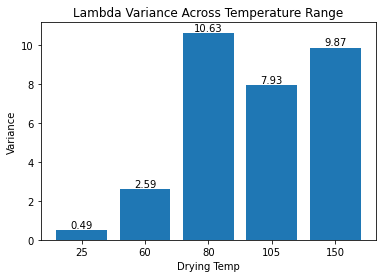

In [166]:
# Create a bar plot
bars = [str(x) for x in drying_temp_range]
plt.bar(bars, variance_lst)

# Round and display the numbers on top of the bars
for i, v in enumerate(variance_lst):
    plt.text(bars[i], v, f'{v:.2f}', ha='center', va='bottom')

# Add labels and title
plt.xlabel('Drying Temp')
plt.ylabel('Variance')
plt.title('Lambda Variance Across Temperature Range')

# Show the plot
plt.show()

DT Liquid

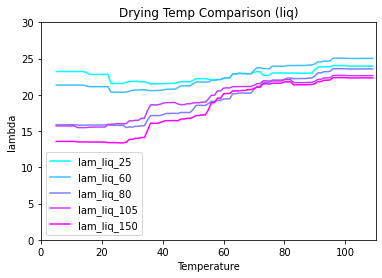

In [172]:
ew = 1100
cast = 0
thickness = 125
pt = 1
#drying_temp = 80;
#temp = 100
Eq_hr = 90
#group 1
eq_range = np.arange(25,200,1)
temp_range = np.arange(5,110,1)

drying_temp_range = [25, 60,80,105, 150]
styles = ['-','--',':', '-.']
cmap = plt.get_cmap('cool')
for i in range(0,len(drying_temp_range)):
    X_vap = [[ew,cast,thickness,pt,drying_temp_range[i],t,0,100,chem_pot(100,t),Eq_hr] for t in temp_range]
    lam_vap = rg_2.predict(X_vap)
    X_liq = [[ew,cast,thickness,pt,drying_temp_range[i],t,1,100,chem_pot(100,t),Eq_hr] for t in temp_range]
    lam_liq = rg_2.predict(X_liq)

    #plt.plot(temp_range, lam_vap, label=f'lam_vap_{drying_temp_range[i]}', color='red', linestyle = styles[i])
    #plt.plot(temp_range, lam_liq, label=f'lam_liq_{drying_temp_range[i]}', color='blue',linestyle = styles[i]) 
    color = cmap(i / (len(drying_temp_range) - 1)) 
    plt.plot(temp_range, lam_liq, label=f'lam_liq_{drying_temp_range[i]}', color=color)    
  
    plt.legend()


# lam_liq - lam_vap;
# plt.plot(temp_range, lam_vap, label='lam_vap', color='red')
# plt.plot(temp_range, lam_liq, label='lam_liq', color='blue')
# #plt.plot(temp_range, lam_vap1, label='lam_vap_pt', color='red', linestyle = '--')
# #plt.plot(temp_range, lam_liq1, label='lam_liq_pt', color='blue', linestyle = '--')

# # experimental data scatter
# plt.scatter(pt_liq.Temperature, pt_liq['lambda'],color = 'red')

plt.xlabel('Temperature')
plt.ylabel('lambda')
plt.ylim([0,30])
plt.xlim([0,110])
plt.title('Drying Temp Comparison (liq)')
plt.legend()

In [140]:
1-np.sqrt(5/6)

0.0871290708247231

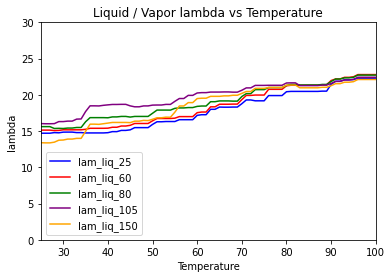

In [135]:
ew = 1100
cast = 0
thickness = 125
pt = 0
#drying_temp = 80;
#temp = 100
Eq_hr = 90
#group 1
eq_range = np.arange(25,200,1)
temp_range = np.arange(5,110,1)

drying_temp_range = [25, 60,80,105, 150]
#drying_temp_range = np.sort(df_2.Drying_Temp.unique())
styles = ['-','--',':', '-.']
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i in range(0,len(drying_temp_range)):
    X_vap = [[ew,cast,thickness,pt,drying_temp_range[i],t,0,100,chem_pot(100,t),Eq_hr] for t in temp_range]
    lam_vap = rg_2.predict(X_vap)
    X_liq = [[ew,cast,thickness,pt,drying_temp_range[i],t,1,100,chem_pot(100,t),Eq_hr] for t in temp_range]
    lam_liq = rg_2.predict(X_liq)

    #plt.plot(temp_range, lam_vap, label=f'lam_vap_{drying_temp_range[i]}', color='red', linestyle = styles[i])
    #plt.plot(temp_range, lam_liq, label=f'lam_liq_{drying_temp_range[i]}', color='blue',linestyle = styles[i])  
    plt.plot(temp_range, lam_liq, label=f'lam_liq_{drying_temp_range[i]}', color=colors[i])    
  
    plt.legend()


# lam_liq - lam_vap;
# plt.plot(temp_range, lam_vap, label='lam_vap', color='red')
# plt.plot(temp_range, lam_liq, label='lam_liq', color='blue')
# #plt.plot(temp_range, lam_vap1, label='lam_vap_pt', color='red', linestyle = '--')
# #plt.plot(temp_range, lam_liq1, label='lam_liq_pt', color='blue', linestyle = '--')

# # experimental data scatter
# plt.scatter(pt_liq.Temperature, pt_liq['lambda'],color = 'red')

plt.xlabel('Temperature')
plt.ylabel('lambda')
plt.ylim([0,30])
plt.xlim([25,100])
plt.title('Liquid / Vapor lambda vs Temperature')
plt.legend()

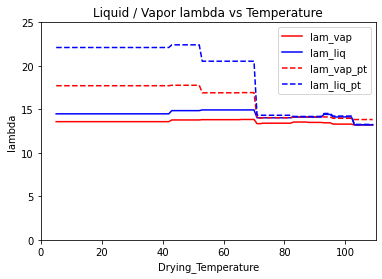

In [ ]:
ew = 1100
cast = 1
thickness = 175
pt = 0
drying_temp = 25;
temp = 20
Eq_hr = 10
#group 1
eq_range = np.arange(25,140,1)
temp_range = np.arange(60,110,1)
X_vap = [[ew,cast,thickness,pt,drying_temp,temp,0,100,chem_pot(100,temp),Eq_hr] for drying_temp in temp_range]
lam_vap = rg_2.predict(X_vap)
X_liq = [[ew,cast,thickness,pt,drying_temp,temp,1,100,chem_pot(100,temp),Eq_hr] for drying_temp in temp_range]
lam_liq = rg_2.predict(X_liq)
#group2
temp_range = np.arange(5,110,1)
X_vap1 = [[ew,cast,thickness,1,drying_temp,temp,0,100,chem_pot(100,temp),Eq_hr] for drying_temp in temp_range]
lam_vap1 = rg_2.predict(X_vap1)
X_liq1 = [[ew,cast,thickness,1,drying_temp,temp,1,100,chem_pot(100,temp),Eq_hr] for drying_temp in temp_range]
lam_liq1 = rg_2.predict(X_liq1)

lam_liq - lam_vap;
plt.plot(temp_range, lam_vap, label='lam_vap', color='red')
plt.plot(temp_range, lam_liq, label='lam_liq', color='blue')
plt.plot(temp_range, lam_vap1, label='lam_vap_pt', color='red', linestyle = '--')
plt.plot(temp_range, lam_liq1, label='lam_liq_pt', color='blue', linestyle = '--')
plt.xlabel('Drying_Temperature')
plt.ylabel('lambda')
plt.ylim([0,25])
plt.xlim([0,110])
plt.title('Liquid / Vapor lambda vs Temperature')
plt.legend()

In [ ]:
lq_low_temp = df[df.LV_id == 1]
lq_low_temp = lq_low_temp[lq_low_temp.Equilibrium_hr]

,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential,Equilibrium_hr
181,1100,1,175.0,1,25,25.0,1.0,100.1,11.0,11412.117042,NaN
182,1100,1,175.0,1,25,40.0,1.0,100.1,12.0,11986.552464,NaN
183,1100,1,175.0,1,25,50.0,1.0,100.1,13.0,12369.509411,NaN
184,1100,1,175.0,1,25,70.0,1.0,100.1,15.0,13135.423307,NaN
185,1100,1,175.0,1,25,80.0,1.0,100.1,18.0,13518.380255,NaN
...,...,...,...,...,...,...,...,...,...,...,...
766,1100,1,175.0,1,105,65.0,1.0,100.1,15.2,12943.944833,0.16
767,1100,1,175.0,1,105,85.0,1.0,100.1,15.9,13709.858728,0.16
768,1100,1,175.0,1,25,27.0,1.0,100.1,21.3,11488.708432,0.16
769,1100,1,175.0,1,25,65.0,1.0,100.1,21.0,12943.944833,0.16


In [ ]:
rg_1.feature_importances_

array([3.36097937e-05, 3.98927378e-03, 3.43205996e-03, 5.85080656e-03,
       3.06889883e-02, 2.22747265e-02, 8.49481091e-03, 7.59118707e-01,
       1.66117017e-01])

In [ ]:
# Below are the regressors from the last fold during CV, not trained on the whole dataset
# I meant to compare these with the one all-seeing regressor trained on the entire data, not good for anything else 

# rg_1=model_scan(X_1, y_1, regressor_class=RandomForestRegressor, max_depth=8, random_state=0)[0] 
# rg_2=model_scan(X_2, y_2, regressor_class=RandomForestRegressor, max_depth=8, random_state=0)[0] 
# rg_3=model_scan(X_3, y_3, regressor_class=RandomForestRegressor, max_depth=8, random_state=0)[0] 

In [ ]:
X_1

array([[1.10000000e+03, 1.00000000e+00, 1.75000000e+02, ...,
        1.00000000e+00, 1.00100000e+02, 1.12206386e+04],
       [1.10000000e+03, 1.00000000e+00, 1.75000000e+02, ...,
        1.00000000e+00, 1.00100000e+02, 1.19865525e+04],
       [1.10000000e+03, 1.00000000e+00, 1.75000000e+02, ...,
        1.00000000e+00, 1.00100000e+02, 1.27524664e+04],
       ...,
       [1.10000000e+03, 0.00000000e+00, 1.60000000e+01, ...,
        0.00000000e+00, 8.00000000e+01, 1.08567865e+04],
       [1.10000000e+03, 0.00000000e+00, 1.60000000e+01, ...,
        0.00000000e+00, 9.00000000e+01, 1.11486024e+04],
       [1.10000000e+03, 0.00000000e+00, 1.60000000e+01, ...,
        0.00000000e+00, 9.80000000e+01, 1.13595870e+04]])

In [ ]:
explainer_1 = shap.Explainer(rg_1)
shap_values_1 = explainer_1(X_1_df)

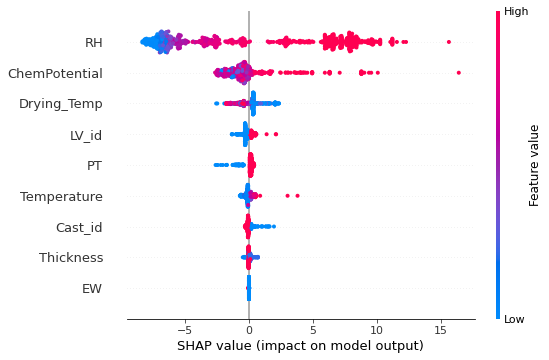

In [ ]:
shap.summary_plot(shap_values_1,X_1,feature_names=x_columns_1)

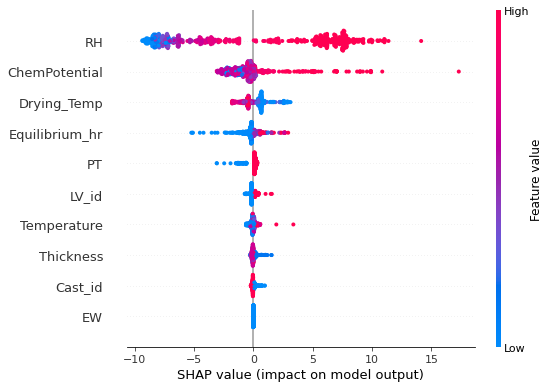

In [ ]:
explainer_2 = shap.Explainer(rg_2)
shap_values_2 = explainer_2(X_2)
shap.summary_plot(shap_values_2,X_2,feature_names=x_columns_2)

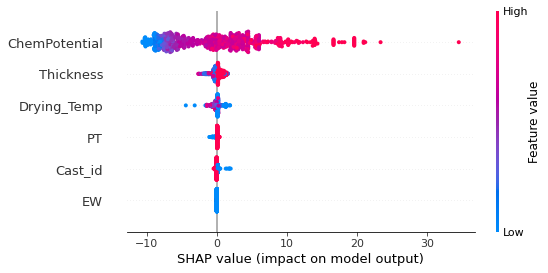

In [ ]:
explainer_3 = shap.Explainer(rg_3)
shap_values_3 = explainer_3(X_3)
shap.summary_plot(shap_values_3,X_3,feature_names=x_columns_3)

In [ ]:
df_2= df_2.reset_index()
medium_RH = df_2
medium_RH = medium_RH[medium_RH['RH']>=30]
medium_RH = medium_RH[medium_RH['RH'] <=60]
medium_RH

,index,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential,Equilibrium_hr
134,251,1100,1,175.0,1,25,40.0,0.0,30.0,3.453000,8850.874725,10.0
135,252,1100,1,175.0,1,25,40.0,0.0,50.0,4.785000,10180.187051,10.0
140,257,1100,1,175.0,1,25,65.0,0.0,30.0,3.361000,9557.813601,10.0
141,258,1100,1,175.0,1,25,65.0,0.0,50.0,4.693000,10993.301032,10.0
146,263,1100,1,175.0,1,25,90.0,0.0,50.0,4.647000,11806.415014,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
564,799,1100,0,16.0,0,150,25.0,0.0,60.0,4.516777,10144.033446,2.0
572,807,1100,0,16.0,0,150,25.0,0.0,30.0,2.837261,8426.711399,2.0
573,808,1100,0,16.0,0,150,25.0,0.0,40.0,3.367626,9139.464447,2.0
574,809,1100,0,16.0,0,150,25.0,0.0,50.0,3.910540,9692.318662,2.0


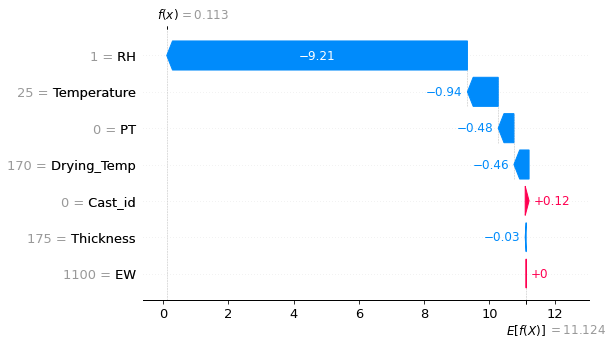

In [ ]:

shap.plots.waterfall(shap_values_1[134])

In [ ]:
df_2[df_2['lambda'] > 10]

,index,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential,Equilibrium_hr
0,0,1100,1,175.0,1,120,20.0,1.0,100.1,12.400000,11220.638568,1.00
1,1,1100,1,175.0,1,120,40.0,1.0,100.1,13.200000,11986.552464,1.00
2,2,1100,1,175.0,1,120,60.0,1.0,100.1,14.000000,12752.466359,1.00
3,3,1100,1,175.0,1,120,70.0,1.0,100.1,12.700000,13135.423307,1.00
4,4,1100,1,175.0,1,120,80.0,1.0,100.1,15.400000,13518.380255,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
532,767,1100,1,175.0,1,105,85.0,1.0,100.1,15.900000,13709.858728,0.16
533,768,1100,1,175.0,1,25,27.0,1.0,100.1,21.300000,11488.708432,0.16
534,769,1100,1,175.0,1,25,65.0,1.0,100.1,21.000000,12943.944833,0.16
535,770,1100,1,175.0,1,25,85.0,1.0,100.1,20.700000,13709.858728,0.16


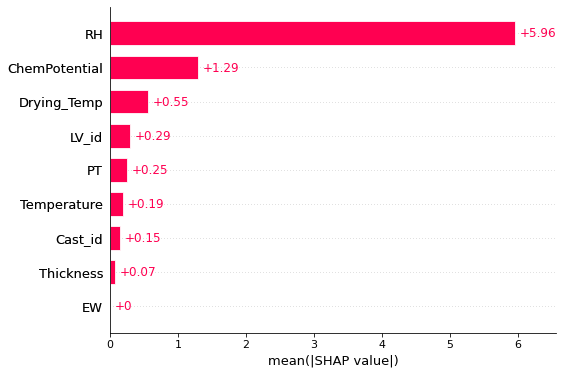

In [ ]:
shap.plots.bar(shap_values_1)

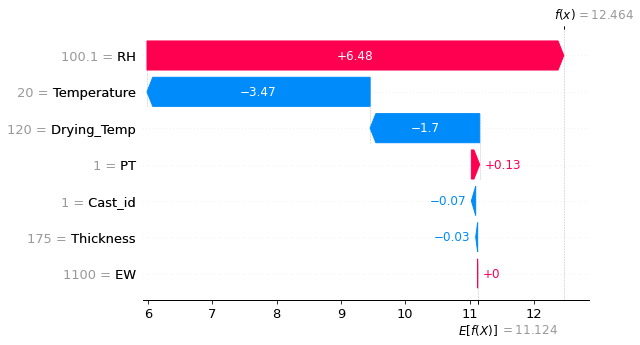

In [ ]:
shap.plots.waterfall(shap_values_1[0])

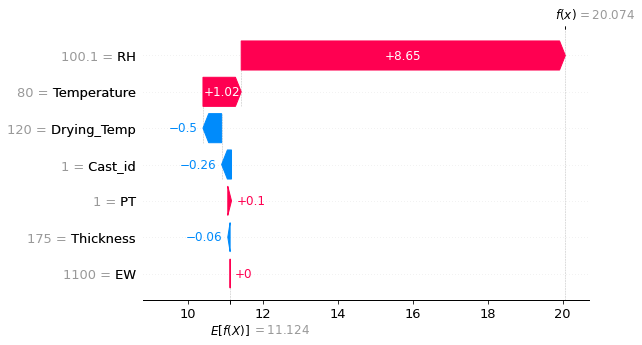

In [ ]:
shap.plots.waterfall(shap_values_1[4])

In [ ]:

df1_score,df2_score, df3_score=[],[],[]

print('X1')
depth_range=range(2,11)
for depth in depth_range:
    print(f'depth: {depth}')
    df1_score.append(validate(X_1, y_1, regressor_class=RandomForestRegressor, max_depth=depth, random_state=0)[1])
   

#max depth: one of the optional parameters of RFregressor. The maximum depth of the tree. 
# If by defalt:None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. 
    
print('X2')
for depth in range(2, 11):
    print(f'depth: {depth}')
    df2_score.append(validate(X_2, y_2, regressor_class=RandomForestRegressor, max_depth=depth, random_state=0)[1])

print('X3')
depth_range=range(2,11)
for depth in depth_range:
    print(f'depth: {depth}')
    df3_score.append(validate(X_3, y_3, regressor_class=RandomForestRegressor, max_depth=depth, random_state=0)[1])
   


X1
depth: 2
mean train score: 0.8243898175060549  ---  mean test score: 0.814799146237684 ---test min/max: 0.77369974621944 | 0.8505823860700299
depth: 3
mean train score: 0.8786715773265538  ---  mean test score: 0.852557235306335 ---test min/max: 0.7841115109647587 | 0.8922506278159927
depth: 4
mean train score: 0.9139975496412539  ---  mean test score: 0.8797370903290685 ---test min/max: 0.7965185756282408 | 0.9176965381423764
depth: 5
mean train score: 0.9380298077597672  ---  mean test score: 0.9027661796028813 ---test min/max: 0.8282875860005403 | 0.9397680676885671
depth: 6
mean train score: 0.9503089843741672  ---  mean test score: 0.9127856084430649 ---test min/max: 0.8384961545639888 | 0.9438607696590471
depth: 7
mean train score: 0.9574111319766202  ---  mean test score: 0.9160849674997759 ---test min/max: 0.8421802144028945 | 0.9473974440039672
depth: 8
mean train score: 0.9621188668761828  ---  mean test score: 0.9155673206362619 ---test min/max: 0.843794364135831 | 0.9471

In [ ]:
df_depth_score=pd.DataFrame()
df_depth_score['depth']=np.arange(2,11)
df_depth_score['df1']=df1_score
df_depth_score['df2']=df2_score
df_depth_score['df3']=df3_score

df_depth_score

,depth,df1,df2,df3
0,2,0.814799,0.821086,0.705643
1,3,0.852557,0.856970,0.724985
2,4,0.879737,0.902908,0.747113
3,5,0.902766,0.929292,0.770716
4,6,0.912786,0.940108,0.787760
5,7,0.916085,0.944163,0.798999
6,8,0.915567,0.946576,0.802376
7,9,0.914195,0.947842,0.804445
8,10,0.912945,0.948418,0.803780


<AxesSubplot:xlabel='depth', ylabel='Score'>

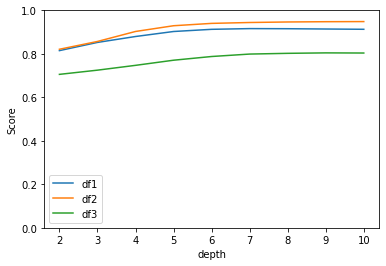

In [ ]:
df_depth_score.plot(x='depth',y=['df1','df2','df3'],ylim=[0,1],ylabel="Score")

<AxesSubplot:xlabel='depth', ylabel='Score(zoomed in)'>

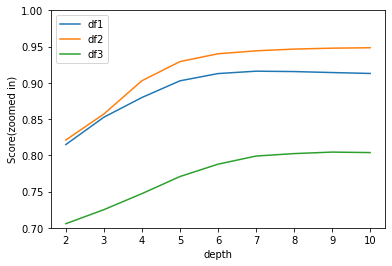

In [ ]:
df_depth_score.plot(x='depth',y=['df1','df2','df3'],ylim=[0.7,1],ylabel="Score(zoomed in)")

## Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
rg_1=RandomForestRegressor()
rg_1.fit(X_1,y_1)
rg_1.score(X_1,y_1)

0.9650137750908262

In [ ]:
sum(rg_1.feature_importances_)

1.0

df1 (raw)

1.352 +/- 0.053
0.344 +/- 0.025
0.074 +/- 0.006
0.037 +/- 0.007
0.022 +/- 0.003
0.021 +/- 0.004
0.006 +/- 0.001
0.005 +/- 0.003
0.000 +/- 0.000


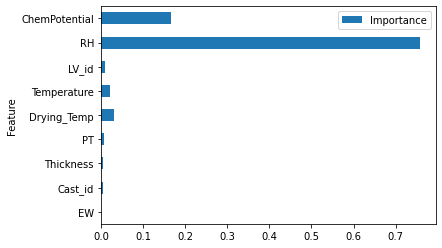

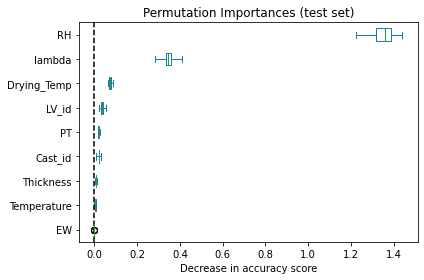

In [ ]:
feature_importance_ranking = {
    'Feature': [],
    'Importance': []
}
for i in range(len(x_columns_1)):
    feature_importance_ranking['Feature'].append(x_columns_1[i])
    feature_importance_ranking['Importance'].append(rg_1.feature_importances_[i])
df_feature_importance_ranking = pd.DataFrame(feature_importance_ranking)
df_feature_importance_ranking.plot.barh(x='Feature', y='Importance', rot=0)

r = permutation_importance(rg_1[0], X_1, y_1, n_repeats=30, random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(#f"{diabetes.feature_names[i]:<8}"\
            f"{r.importances_mean[i]:.3f}"\
            f" +/- {r.importances_std[i]:.3f}")

sorted_importances_idx = r.importances_mean.argsort()
importances = pd.DataFrame(
    r.importances[sorted_importances_idx].T,
    columns=df_1.columns[sorted_importances_idx],
)
# importances_rf = pd.DataFrame(
#     rg_1.feature_importances_
#     columns=df_1.columns[sorted_importances_idx],
# )
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [ ]:
r.importances

array([[0.02146797, 0.01779969, 0.01805437, 0.01589339, 0.0237367 ,
        0.01625616, 0.02551979, 0.02383751, 0.01281654, 0.02232735,
        0.01962397, 0.01615362, 0.01675127, 0.02140833, 0.01864346,
        0.01522081, 0.02107292, 0.02472898, 0.02577618, 0.02187358,
        0.02400023, 0.0193478 , 0.02063365, 0.02626094, 0.02457912,
        0.02275505, 0.01787978, 0.02402281, 0.02434606, 0.021719  ],
       [0.01387913, 0.01469007, 0.01042761, 0.01188738, 0.00981348,
        0.01024454, 0.01033559, 0.00990279, 0.00980353, 0.0088863 ,
        0.01117586, 0.01052203, 0.00545201, 0.0135418 , 0.01382742,
        0.00983905, 0.00891189, 0.0148521 , 0.01569496, 0.0094432 ,
        0.01165025, 0.00910896, 0.01590544, 0.0066269 , 0.01386985,
        0.0090029 , 0.01521512, 0.01316567, 0.01083349, 0.0117296 ],
       [0.03321257, 0.0220863 , 0.0278616 , 0.02386798, 0.02399746,
        0.02670943, 0.02503886, 0.02757609, 0.02756622, 0.02590487,
        0.02380536, 0.03132715, 0.02231814, 0.

In [ ]:
rg_1[0].feature_importances_

In [ ]:
df_1.corr()

,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential
EW,1.000000,0.069615,-0.122599,0.039716,-0.091972,-0.083060,-0.072025,-0.003835,-0.046139,-0.016376
Cast_id,0.069615,1.000000,0.811017,0.422709,-0.168658,0.144832,0.283685,0.238325,0.260241,0.199296
Thickness,-0.122599,0.811017,1.000000,0.445026,-0.070783,0.213964,0.281845,0.213996,0.275044,0.203138
PT,0.039716,0.422709,0.445026,1.000000,-0.272789,0.262638,0.169797,0.181183,0.246522,0.216199
Drying_Temp,-0.091972,-0.168658,-0.070783,-0.272789,1.000000,0.110090,0.243758,0.235887,0.233050,0.187975
Temperature,-0.083060,0.144832,0.213964,0.262638,0.110090,1.000000,0.240560,0.205923,0.476671,0.480760
LV_id,-0.072025,0.283685,0.281845,0.169797,0.243758,0.240560,1.000000,0.601261,0.744567,0.450832
RH,-0.003835,0.238325,0.213996,0.181183,0.235887,0.205923,0.601261,1.000000,0.773836,0.848655
lambda,-0.046139,0.260241,0.275044,0.246522,0.233050,0.476671,0.744567,0.773836,1.000000,0.701880
ChemPotential,-0.016376,0.199296,0.203138,0.216199,0.187975,0.480760,0.450832,0.848655,0.701880,1.000000


0.682 +/- 0.041
0.419 +/- 0.031
0.191 +/- 0.018
0.030 +/- 0.003
0.003 +/- 0.001


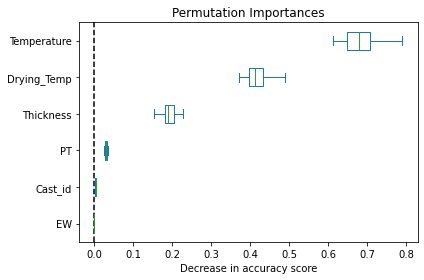

In [ ]:

r = permutation_importance(rg_1[0], X_1, y_1, n_repeats=30, random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(#f"{diabetes.feature_names[i]:<8}"\
            f"{r.importances_mean[i]:.3f}"\
            f" +/- {r.importances_std[i]:.3f}")

sorted_importances_idx = r.importances_mean.argsort()
importances = pd.DataFrame(
    r.importances[sorted_importances_idx].T,
    columns=df_1.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

df2 (df1 w/ Ehr)

In [ ]:
df_2.shape

(580, 11)

mean train score: 0.990408198151106  ---  mean test score: 0.9478419387984579


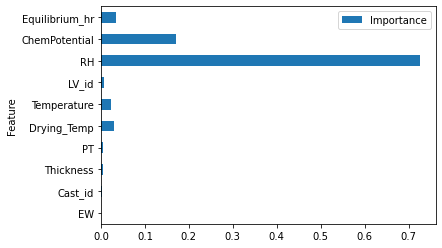

In [ ]:
rg_2 = model_scan(X_2, y_2, regressor_class=RandomForestRegressor, max_depth=9, random_state=0)
feature_importance_ranking = {
    'Feature': [],
    'Importance': []
}
for i in range(len(x_columns_2)):
    feature_importance_ranking['Feature'].append(x_columns_2[i])
    feature_importance_ranking['Importance'].append(rg_2[0].feature_importances_[i])
df_feature_importance_ranking = pd.DataFrame(feature_importance_ranking)
df_feature_importance_ranking.plot.barh(x='Feature', y='Importance', rot=0);

In [ ]:
X_2_df = make_X_y_df(df_2)[0]
X_2_df[X_2_df['RH']>99]

,index,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,ChemPotential,Equilibrium_hr
0,0,1100,1,175.0,1,120,20.0,1.0,100.1,11220.638568,1.00
1,1,1100,1,175.0,1,120,40.0,1.0,100.1,11986.552464,1.00
2,2,1100,1,175.0,1,120,60.0,1.0,100.1,12752.466359,1.00
3,3,1100,1,175.0,1,120,70.0,1.0,100.1,13135.423307,1.00
4,4,1100,1,175.0,1,120,80.0,1.0,100.1,13518.380255,1.00
...,...,...,...,...,...,...,...,...,...,...,...
531,766,1100,1,175.0,1,105,65.0,1.0,100.1,12943.944833,0.16
532,767,1100,1,175.0,1,105,85.0,1.0,100.1,13709.858728,0.16
533,768,1100,1,175.0,1,25,27.0,1.0,100.1,11488.708432,0.16
534,769,1100,1,175.0,1,25,65.0,1.0,100.1,12943.944833,0.16


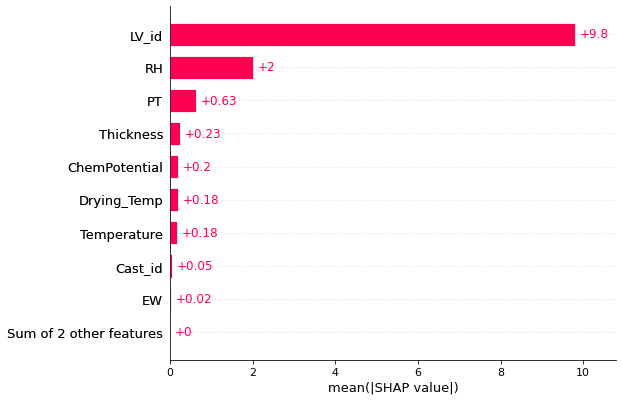

In [ ]:
shap.plots.bar(shap_values_2)

df3 (chemPot replace RH Temp)

mean train score: 0.928383425309136  ---  mean test score: 0.8124511269665647


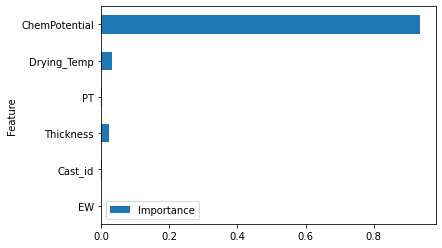

In [ ]:
rg_3 = model_scan(X_3, y_3, regressor_class=RandomForestRegressor, max_depth=9, random_state=0)
feature_importance_ranking = {
    'Feature': [],
    'Importance': []
}
for i in range(len(x_columns_3)):
    feature_importance_ranking['Feature'].append(x_columns_3[i])
    feature_importance_ranking['Importance'].append(rg_3[0].feature_importances_[i])
df_feature_importance_ranking = pd.DataFrame(feature_importance_ranking)
_ = df_feature_importance_ranking.plot.barh(x='Feature', y='Importance', rot=0)

In [ ]:
rg_1[0].feature_importances_

array([1.97743233e-05, 3.70806217e-03, 4.03187883e-03, 5.73300777e-03,
       4.35266303e-02, 7.48097656e-02, 5.32927695e-01, 3.35243186e-01])

# Fitting Features

In [ ]:
fit_params=pd.read_csv("thermo_fit_params.csv")
fit_params.head(2)

,Study,Year,Membrane,EW,Cast,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,E0,beta_HM
0,Berlinger,2020,D2020,1100,Cst,0,16,0,150,25,0,44,44,314236102.6,0.046085
1,Choi,2005,Ncast,1100,Cst,0,175,0,170,25,0,11,11,229768853.4,0.053402


In [ ]:
fit_params_clean= fit_params.drop(['Study','Year','Membrane','Cast','RH','lambda'],axis=1)
fit_params_clean.head(2)

,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,E0,beta_HM
0,1100,0,16,0,150,25,0,314236102.6,0.046085
1,1100,0,175,0,170,25,0,229768853.4,0.053402


E0

In [ ]:
X_E0, y_E0, x_columns_E0 = make_X_y(fit_params_clean.drop("beta_HM",axis=1),"E0")
print(f'X_E0: {X_E0.shape}, y_E0: {y_E0.shape}')

X_E0: (45, 7), y_E0: (45,)


In [ ]:
#rg_E0 = model_scan(X_E0, y_E0, regressor_class=RandomForestRegressor, max_depth=9, random_state=0)
print(rg_E0[0].feature_importances_)
columns=fit_params_clean.drop(["beta_HM","E0"],axis=1).columns
feature_importance_ranking = {
    'Feature': [],
    'Importance_E0': []
}
for i in range(len(columns)):
    feature_importance_ranking['Feature'].append(columns[i])
    feature_importance_ranking['Importance_E0'].append(rg_E0[0].feature_importances_[i])
df_feature_importance_ranking_E0 = pd.DataFrame(feature_importance_ranking)
df_feature_importance_ranking_E0.plot.barh(x='Feature', y='Importance_E0', rot=0);

NameError: name 'rg_E0' is not defined

<img src="./Plots/thermo_corr.png">

Beta_HM

X_beta: (45, 7), y_beta: (45,)
mean train score: 0.8274349198590838  ---  mean test score: -2.632841759000653
[0.02709345 0.08430754 0.06130881 0.01743605 0.24354734 0.56630682
 0.        ]


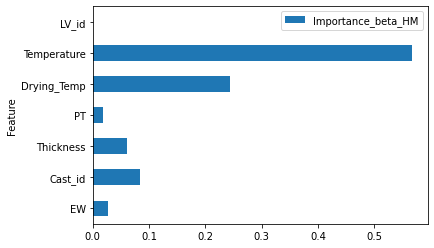

In [ ]:
X_beta, y_beta, x_columns_beta = make_X_y(fit_params_clean.drop("E0",axis=1),"beta_HM")
print(f'X_beta: {X_beta.shape}, y_beta: {y_beta.shape}')

rg_beta = model_scan(X_beta, y_beta, regressor_class=RandomForestRegressor, max_depth=9, random_state=0)
print(rg_beta[0].feature_importances_)
columns=fit_params_clean.drop(["beta_HM","E0"],axis=1).columns
feature_importance_ranking = {
    'Feature': [],
    'Importance_beta_HM': []
}
for i in range(len(columns)):
    feature_importance_ranking['Feature'].append(columns[i])
    feature_importance_ranking['Importance_beta_HM'].append(rg_beta[0].feature_importances_[i])
df_feature_importance_ranking_beta = pd.DataFrame(feature_importance_ranking)
df_feature_importance_ranking_beta.plot.barh(x='Feature', y='Importance_beta_HM', rot=0);

<img src="./Plots/thermo_corr.png">

In [ ]:
combined_importances=pd.merge(left=df_feature_importance_ranking_E0, right=df_feature_importance_ranking_beta, on="Feature",how="inner")
combined_importances

,Feature,Importance_E0,Importance_beta_HM
0,EW,0.057514,0.027093
1,Cast_id,0.026010,0.084308
2,Thickness,0.130487,0.061309
3,PT,0.020360,0.017436
4,Drying_Temp,0.197658,0.243547
5,Temperature,0.567971,0.566307
6,LV_id,0.000000,0.000000


# Train Score (Studies)                
sept. 27

In [ ]:
df_named = dvs_data.drop(['Year','Membrane','Cast','LV','RH_r','Pret_Time','Equilibrium_hr'],axis=1)
df_named = df_named[df_named['lambda'].notnull()] 
df_named = df_named[df_named['Thickness'].notnull()]
df_named = df_named[df_named['Study'] != 'Alberti'] 
df_named

,Study,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential
155,Broka,1100,1,175.0,1,120,22.0,0.0,99.0,14.500000,11270.128798
156,Broka,1100,1,175.0,1,120,25.0,0.0,99.0,14.000000,11384.740277
157,Broka,1100,1,175.0,1,120,30.0,0.0,99.0,12.500000,11575.759410
158,Broka,1100,1,175.0,1,120,36.0,0.0,99.0,10.500000,11804.982368
159,Broka,1100,1,175.0,1,120,44.0,0.0,99.0,10.000000,12110.612980
...,...,...,...,...,...,...,...,...,...,...,...
810,Berlinger,1100,0,16.0,0,150,25.0,0.0,60.0,4.530136,10144.033446
811,Berlinger,1100,0,16.0,0,150,25.0,0.0,70.0,5.303879,10525.952854
812,Berlinger,1100,0,16.0,0,150,25.0,0.0,80.0,6.430028,10856.786493
813,Berlinger,1100,0,16.0,0,150,25.0,0.0,90.0,7.734861,11148.602445


In [ ]:
studies = df_named.Study.unique()
studies

array(['Broka', 'Choi', 'Gallagher', 'Hinatsu', 'Hsu', 'Jalani', 'James',
       'Kidena', 'Kim et al.', 'Kreuer', 'Kusoglu', 'Lee', 'Legras',
       'Luo', 'Maldonado', 'Mangiagli', 'Morris and Sun', 'Ochi',
       'Onishi', 'Peron', 'Rieke', 'Takata', 'Thompson', 'Zawodzinski',
       'Berlinger'], dtype=object)

## Single Removal

In [ ]:
result=[]
#result.index=studies
for name in studies: # Round-Robin Drop study
    
    #df_exclude = pd.concat(df_named,df_named[df_named.Study == name]).drop_duplicates(keep=False)
    df_exclude= df_named.append(df_named[df_named.Study == name]).drop_duplicates(keep=False)
    df_exclude.drop("Study",axis=1,inplace=True)
    X_exc,y_exc,exc_column = make_X_y(df_exclude)
    rg_temp = RandomForestRegressor(max_depth=7,random_state=0)
    rg_temp.fit(X_exc,y_exc)
    result.append(rg_temp.score(X_exc,y_exc)) # fit and score same set of data after removal. measure homogeniety 


In [ ]:
pd.DataFrame({
    "Excluded Study": studies,
    "Score of Remaining": result
})

,Excluded Study,Score of Remaining
0,Broka,0.967659
1,Choi,0.968175
2,Gallagher,0.968154
3,Hinatsu,0.979447
4,Hsu,0.968627
5,Jalani,0.968348
6,James,0.967915
7,Kidena,0.968958
8,Kim et al.,0.968685
9,Kreuer,0.966223


## Procedural Removal 

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()  #argmin() returns index of minimum value
    return array[idx]

In [ ]:

#result.index=studies
X_all,y_all,all_column = make_X_y(df_named.drop("Study",axis=1)) # all studies

def get_score(dataframe, compare_func, result_lst=[],result_sequence=[],drop_count=1): 
    if len(dataframe.Study.unique())==1: # stop recursion
        #print(result_lst)
        return result_lst,result_sequence
    else:    
        temp_dict = {'name':[], 'score':[]}
        for name in dataframe.Study.unique():
            df_exclude= dataframe.append(dataframe[dataframe.Study == name]).drop_duplicates(keep=False)
            df_exclude.drop("Study",axis=1,inplace=True)
            X_exc,y_exc,exc_column = make_X_y(df_exclude)
            rg_temp = RandomForestRegressor(max_depth=7,random_state=0)
            rg_temp.fit(X_exc,y_exc)
            temp_dict['name'].append(name)
            temp_dict['score'].append(rg_temp.score(X_all,y_all)) # always testing on 
        return_val = compare_func(temp_dict['score'])
        
        result_lst.append(return_val) # compare_func example: max(): add max score to list for later return
        return_name = temp_dict['name'][temp_dict['score'].index(find_nearest(temp_dict['score'],return_val))]
        result_sequence.append(return_name)
        print(f"at this stage {return_val}")
        #print(f"at this stage {result_sequence}")
        print(f"dropped names:{drop_count}")

        next_df = dataframe[dataframe.Study != return_name]
        return get_score(next_df, compare_func, result_lst,result_sequence,drop_count+1)

#best_lst=get_score(df_named[df_named['Study'].isin( ['Alberti','Berlinger','Takata','Kusoglu'])],max,[],[])
#worst_lst=get_score(df_named[df_named['Study'].isin( ['Alberti','Berlinger','Takata','Kusoglu'])],min,[],[])



In [ ]:

best_lst = get_score(df_named,max,[],[])
worst_lst = get_score(df_named,min,[],[])

at this stage 0.9704212644273306
dropped names:1
at this stage 0.9702123152286726
dropped names:2
at this stage 0.9701402537274083
dropped names:3
at this stage 0.9698228180962918
dropped names:4
at this stage 0.9695953984636548
dropped names:5
at this stage 0.969411403538408
dropped names:6
at this stage 0.9691189956919096
dropped names:7
at this stage 0.9689997308366517
dropped names:8
at this stage 0.9683550845382013
dropped names:9
at this stage 0.9677401273142796
dropped names:10
at this stage 0.9671600294999151
dropped names:11
at this stage 0.9667045796600708
dropped names:12
at this stage 0.9652185277084024
dropped names:13
at this stage 0.964431581360229
dropped names:14
at this stage 0.9609546158103411
dropped names:15
at this stage 0.957179411017518
dropped names:16
at this stage 0.9547488293796721
dropped names:17
at this stage 0.9519819774155657
dropped names:18
at this stage 0.9493394989414051
dropped names:19
at this stage 0.9430126866115172
dropped names:20
at this stag

In [ ]:
median_lst=get_score(df_named,np.median,[],[])

at this stage 0.9687096417380472
dropped names:1
at this stage 0.9682095496048082
dropped names:2
at this stage 0.9676941170723419
dropped names:3
at this stage 0.9666232784516802
dropped names:4
at this stage 0.9658840473441896
dropped names:5
at this stage 0.9644829500776162
dropped names:6
at this stage 0.9643001861270322
dropped names:7
at this stage 0.9619591155327119
dropped names:8
at this stage 0.9599165352824639
dropped names:9
at this stage 0.9583188871546405
dropped names:10
at this stage 0.956747908495362
dropped names:11
at this stage 0.953432621600909
dropped names:12
at this stage 0.9499928206077541
dropped names:13
at this stage 0.9474493598672729
dropped names:14
at this stage 0.9449695490177908
dropped names:15
at this stage 0.9410076644851632
dropped names:16
at this stage 0.9387104943286856
dropped names:17
at this stage 0.9301799996945987
dropped names:18
at this stage 0.9251113681275207
dropped names:19
at this stage 0.9213594367152902
dropped names:20
at this sta

In [ ]:
worst_lst

[0.8325376707486398, 0.2297043423214823, 0.20083092265023172]

In [ ]:
len(df_named.Study.unique())

26

In [ ]:
len(best_lst)

50

In [ ]:
df_bounds = pd.DataFrame({
    "best":best_lst[0],
    "worst":worst_lst[0],
    "median":median_lst[0],
})
df_bounds_names = pd.DataFrame({
    "best":best_lst[1],
    "best score":best_lst[0],
    "worst":worst_lst[1],
    "worst score":worst_lst[0],
    "median":median_lst[1],
    "median score":median_lst[0]
})
df_bounds_names=df_bounds_names.iloc[:24,:]
df_bounds = df_bounds.iloc[:24,:]
df_bounds_names.set_index(np.arange(1,25))

,best,best score,worst,worst score,median,median score
1,James,0.970421,Kusoglu,0.932822,Zawodzinski,0.968710
2,Thompson,0.970212,Maldonado,0.891707,Takata,0.968210
3,Ochi,0.970140,Onishi,0.872860,Peron,0.967694
4,Morris and Sun,0.969823,Luo,0.840817,Hsu,0.966623
5,Choi,0.969595,Zawodzinski,0.819859,Kidena,0.965884
6,Legras,0.969411,Kreuer,0.801063,Jalani,0.964483
7,Hsu,0.969119,Kidena,0.787768,Berlinger,0.964300
8,Lee,0.969000,Thompson,0.769387,Hinatsu,0.961959
9,Mangiagli,0.968355,Peron,0.690470,Morris and Sun,0.959917
10,Gallagher,0.967740,Hinatsu,0.577792,Legras,0.958319


In [ ]:
df_bounds;

This is with all features,
but this score change might be different if we use less features, such as only temperature, RH --> do we still need 15~20 studies?
temperature analysis?
[rh, temp, thickness]
[rh, PT]

TO DO: 
- Run with Low_temp data

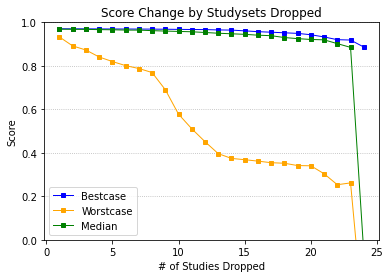

In [ ]:
plt.plot(np.arange(1,25), df_bounds.best, lw=1, c='blue', marker='s', ms=4, label='Bestcase')
plt.plot(np.arange(1,25), df_bounds.worst, lw=1, c='orange', marker='s', ms=4, label='Worstcase')
plt.plot(np.arange(1,25), df_bounds['median'], lw=1, c='green', marker='s', ms=4, label='Median')

plt.title('Score Change by Studysets Dropped')
plt.xlabel('# of Studies Dropped')
plt.ylabel('Score')
plt.ylim([0,1])
plt.legend()
plt.grid(linestyle = ':',axis='y')

In [ ]:
df_named.Study.value_counts().to_frame()

,Study
Kusoglu,219
Alberti,126
Maldonado,71
Kreuer,56
Berlinger,44
Kidena,26
Zawodzinski,18
Onishi,18
Luo,16
Peron,16


In [ ]:
df_named[df_named['Study'].isin( ['Alberti','Berlinger','Takata'])]

,Study,EW,Cast_id,Thickness,PT,Drying_Temp,Temperature,LV_id,RH,lambda,ChemPotential
0,Alberti,1100,1,175.0,1,120,20.0,1.0,100.1,12.400000,11220.638568
1,Alberti,1100,1,175.0,1,120,40.0,1.0,100.1,13.200000,11986.552464
2,Alberti,1100,1,175.0,1,120,60.0,1.0,100.1,14.000000,12752.466359
3,Alberti,1100,1,175.0,1,120,70.0,1.0,100.1,12.700000,13135.423307
4,Alberti,1100,1,175.0,1,120,80.0,1.0,100.1,15.400000,13518.380255
...,...,...,...,...,...,...,...,...,...,...,...
810,Berlinger,1100,0,16.0,0,150,25.0,0.0,60.0,4.530136,10144.033446
811,Berlinger,1100,0,16.0,0,150,25.0,0.0,70.0,5.303879,10525.952854
812,Berlinger,1100,0,16.0,0,150,25.0,0.0,80.0,6.430028,10856.786493
813,Berlinger,1100,0,16.0,0,150,25.0,0.0,90.0,7.734861,11148.602445


In [ ]:
dict= {'name':['a','b','c'], 'val':[1,2,3]}
dict['name'][dict['val'].index(3)]

'c'